In [272]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns
import glob
import subprocess
import math
import random
import time
from joblib import dump, load
import pickle

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles, GetScaffoldForMol
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.ML.Cluster import Butina

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve, average_precision_score, plot_precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, confusion_matrix

In [273]:
# functions and classes
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_<{self.categories_[i][j]}>')
                j += 1
        return new_columns

def multiple_labels(df, col_name):
    '''
    Splits compounds with multiple labels into separate entries with single labels
    '''
    df[col_name] = df[col_name].str.split(', ')
    df = df.explode(col_name, ignore_index=True)
    return df

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def ord_to_OHE(ord_preds, n_classes):
    '''
    converts ordinal values to OHE values
    '''
    OHE_preds = []
    for y in ord_preds:
        OHE_pred = np.zeros(np.max(n_classes))
        OHE_pred[y] = 1
        OHE_preds.append(OHE_pred.astype(int))
    return np.vstack(OHE_preds)

def get_preds(clfs, x, training_df, human=False):
    '''
    gets str predictions
    '''
    one = OneHotEncoder()
    df = training_df['labels'].to_frame()
    one.fit(df)
    
    test_combos = x
    rfc = clfs[0]
    svm = clfs[1]
    gpc = clfs[2]
    knn = clfs[3]
    n_classes = len(set(test_df['labels']))
    
    rfc_ord_preds = np.argmax(rfc.predict_proba(test_combos), axis=1)
    rfc_preds = ord_to_OHE(rfc_ord_preds,n_classes)
    svm_ord_preds = svm.predict(test_combos)
    svm_preds = ord_to_OHE(svm_ord_preds,n_classes)
    gpc_ord_preds = gpc.predict(test_combos)
    gpc_preds = ord_to_OHE(gpc_ord_preds,n_classes)
    knn_ord_preds = knn.predict(test_combos)
    knn_preds = ord_to_OHE(knn_ord_preds,n_classes)
    all_preds = {'rfc':one.inverse_transform(rfc_preds), 
                 'svm':one.inverse_transform(svm_preds), 
                 'gpc':one.inverse_transform(gpc_preds), 
                 'knn':one.inverse_transform(knn_preds)}
    return all_preds

# plotting auROC / auPR; gets redefined later due to different save settings
def plot_multiclass_roc(type_of_class, y_score, y_test, ordered_labels, type_of_input, figsize=(8, 6)):
    '''
    plots ROC and PR curves
    '''
    n_classes = len(ordered_labels)
    if type_of_class == 'rfc' or type_of_class == 'gpc' or type_of_class == 'knn':
        y_score = clf.predict_proba(X_test) # this makes gpc work even though it's predicting numeric class
    elif type_of_class == 'svm':
        y_score = clf.decision_function(X_test)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    precision = dict()
    recall = dict()
    prc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        prc_auc[i] = average_precision_score(y_test[:, i], y_score[:, i])
    roc_auc[n_classes+1] = roc_auc_score(y_test, y_score, multi_class='ovr', average='micro')
    prc_auc[n_classes+1] = average_precision_score(y_test, y_score, average="micro")
    
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    plt.rc('font',size=24)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
#     ax.set_title('Receiver operating characteristic curve')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='%s (area = %0.4f)' % (ordered_labels[i],roc_auc[i]), linewidth=4)
    ax.plot([], [], ' ', label='Micro-averaged AUROC: %0.4f' % roc_auc[n_classes+1])
    leg = ax.legend(loc="lower center",fontsize=18)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

    # Change to location of the legend. 
    xOffset = -1.1
    bb.y0 += xOffset
    bb.y1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


    ax.grid(alpha=.4)
    sns.despine()
    fig.savefig('../outputs/'+type_of_class+'_ROC_multiclass_nonhuman_'+type_of_input+'.png', bbox_inches='tight')
    
    # prc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
#     ax.set_title('Precision Recall curve')
    for i in range(n_classes):
        ax.plot(recall[i], precision[i], label='%s (area = %0.4f)' % (ordered_labels[i], prc_auc[i]), linewidth=4)
    ax.plot([], [], ' ', label='Micro-averaged precision: %0.4f' % prc_auc[n_classes+1])
    leg = ax.legend(loc="lower center",fontsize=20)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

    # Change to location of the legend. 
    xOffset = -1.1
    bb.y0 += xOffset
    bb.y1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

    ax.grid(alpha=.4)
    sns.despine()
    fig.savefig('../outputs/'+type_of_class+'_PRC_multiclass_nonhuman_'+type_of_input+'.png', bbox_inches='tight')
    plt.show()
    
    return [roc_auc, prc_auc]

def auroc_aupr_barchart(plot_type, y1s, y2s, class_list, clf_list, width=0.05):
    '''
    plots auroc and aupr barchart
    '''
    colors = list(mcolors.TABLEAU_COLORS)[:len(class_list)]
    # xs: list of offset x values for each class
    xs = [np.arange(len(clf_list))+width*i for i in range(2*len(class_list))]
    fig, ax = plt.subplots(figsize=(10,6))
    
    odd = False
    for class_idx, x in enumerate(xs):
        if odd:
            class_idx = int((class_idx+1)/2-1)
            heights = [ylist[0][class_idx] for ylist in y1s]
            plt.bar(x=x,height=heights,width=width,label=class_list[class_idx]+' auROC',align='edge',color=colors[class_idx],edgecolor='black',alpha=0.6,hatch='//')
        else:
            class_idx = int(class_idx/2)
            heights = [ylist[0][class_idx] for ylist in y2s]
            plt.bar(x=x,height=heights,width=width,label=class_list[class_idx]+' auPR',align='edge',color=colors[class_idx],edgecolor='black')
        odd = not odd
    plt.xlabel('Classifier')
    plt.ylabel(plot_type)
    plt.xticks([r+width*len(class_list) for r in range(len(clf_list))], clf_list)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.savefig('../outputs/chemprop_predict_human_aupr_auroc.png',bbox_inches='tight')
    
def get_fps(df):
    '''
    gets RDKFingerprints from dataframe 
    '''
    mols = [Chem.MolFromSmiles(x) for x in df['canon_SMILES']]
    df['mols'] = mols
    fps = [Chem.RDKFingerprint(x) for x in mols if x is not None]
    return fps

# Part 1: Read in data

In [274]:
# get morgan fingerprints for all
data_dir = '../data/'
# file_name = 'abx_MOA_fully_relabeled.csv'
file_name = 'abx_MOA_fully_relabeled_v3.csv'
file_path = data_dir+file_name

drugs = pd.read_csv(file_path)
print('initial length:',len(drugs))
not_nans = [type(smi) != float for smi in list(drugs['canon_SMILES'])]
drugs = drugs[not_nans] # filter for having SMILE
print('filtered for SMILES:',len(drugs))

labeled = [moa != 'unknown' for moa in list(drugs['labels'])]
labeled_drugs = drugs[labeled] # filter labeled drugs i.e. not unknown
print('labeled drugs:',len(labeled_drugs))
labeled_drugs = multiple_labels(labeled_drugs,'labels') # dealing with multiple MOA
labeled_drugs.replace('DNA','nucleic acid', inplace=True)
labeled_drugs.replace('protein','protein biosynthesis', inplace=True)
nonhuman_mask = [label != 'human' for label in labeled_drugs.labels]
nonhuman_drugs = labeled_drugs[nonhuman_mask]

# changing labeled drugs to nonhuman drugs!!
labeled_drugs = nonhuman_drugs.copy()
print('nonhuman drugs:',len(labeled_drugs))
#########################################

# making OHE labels excluding unknown
one = OneHotEncoder()
df = labeled_drugs['labels'].to_frame()
OHE_df = one.fit_transform(df)
OHE_labels = OHE_df.to_numpy()
    
# labeled abx
labeled_mols = [Chem.MolFromSmiles(x) for x in labeled_drugs['canon_SMILES']]
labeled_drugs['mols'] = labeled_mols
labeled_fps = [Chem.RDKFingerprint(x) for x in labeled_mols if x is not None]

# nonhuman drugs
nonhuman_mols = [Chem.MolFromSmiles(x) for x in nonhuman_drugs['canon_SMILES']]
nonhuman_drugs['mols'] = nonhuman_mols
nonhuman_fps = [Chem.RDKFingerprint(x) for x in nonhuman_mols if x is not None]

# training dataset fps
training_drugs = labeled_drugs[[holdout != 'hold_out' for holdout in labeled_drugs.hold_out]]
training_mols = [Chem.MolFromSmiles(x) for x in training_drugs['canon_SMILES']]
training_fps = [Chem.RDKFingerprint(m) for m in training_mols]

initial length: 2856
filtered for SMILES: 2856
labeled drugs: 2835
nonhuman drugs: 2772


<ipython-input-273-3f1d5e155133>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].str.split(', ')


# Part 2: Analyzing performance - Tanimoto score relationship for GPC

In [122]:
# data and weights from GP classifier
aurocs = np.array([0.8299,0.9973,0.9961,0.9695,0.9871,0.9881,1,0.1890,0.9831])
weights = np.array([9,22,365,80,1229,859,57,6,180])
auprs = np.array([0.0110,0.8833,0.9599,0.44,0.9887,0.9783,1.,0.0023,0.9439])

In [123]:
# taking macroaverage and weighted std of auroc values
weighted_avg_and_std(aurocs,weights)

(0.9859501246882795, 0.03826638586208033)

In [124]:
# taking macroaverage and weighted std of auPR values
weighted_avg_and_std(auprs,weights)

(0.9574217670110438, 0.1144823954463332)

In [125]:
# tanimotos: max tanimoto similarity and ten percentile similarities
max_similarity = np.array([0.58,0.989,0.999,0.907,0.998,0.998,.981,0.343,0.999])
ten_percentile = np.array([0.482,0.886,0.842,0.424,0.612,0.652,0.907,0.290,0.835])

In [126]:
# auROC is correlated with max Tanimoto similarity
np.corrcoef(aurocs,max_similarity)

array([[1.        , 0.91819307],
       [0.91819307, 1.        ]])

In [127]:
# auROC is less correlated with max Tanimoto similarity
np.corrcoef(aurocs,ten_percentile)

array([[1.        , 0.69891079],
       [0.69891079, 1.        ]])

In [128]:
# auPR is correlated with max Tanimoto similarity
np.corrcoef(auprs,max_similarity)

array([[1.        , 0.92632879],
       [0.92632879, 1.        ]])

In [129]:
# correlation of auPR and the mean of the top ten percentile is lower
np.corrcoef([auprs,ten_percentile])

array([[1.        , 0.82960152],
       [0.82960152, 1.        ]])

# Part 3: External Model Validation Set (must run part 12, 13 in dataset_analysis.ipynb first)

In [130]:
# loading in the Tanimoto scores of SPARK MIC dataset relative to the training set
with open('../data/least_similar_MIC_data.pkl', 'rb') as file:
    val_dfs = pickle.load(file)
X_smiles = []
y = []
tanimotos = []
for key in val_dfs.keys():
# for key in ['cell division','cell wall','nucleic acid','PMF','protein biosynthesis','membrane','riboswitch']:
    X_smiles.extend(val_dfs[key]['smiles'].to_list()[:5])
    y.extend(val_dfs[key]['labels'].to_list()[:5])
    tanimotos.extend(val_dfs[key]['max_tanimotos'].to_list()[:5])

In [131]:
# creating Brochado SMILES set for chemprop
brochado_df = labeled_drugs.copy()
brochado_mask = [label == 'brochados' for label in brochado_df.hold_out]
brochado_df = brochado_df[brochado_mask]
brochado = pd.DataFrame()
brochado['smiles'] = brochado_df['canon_SMILES']
brochado['labels'] = brochado_df['labels']
brochado.to_csv('../data/chemprop_nonhuman_multilabel_inputs/brochado_val.csv',index=False)

In [132]:
# Including oxidative stress MOA drugs from Brochado et al. in external validation dataset
OS_mask = [label == 'oxidative stress' for label in brochado_df.labels]
brochado_df = brochado_df[OS_mask]
OS_mols = [Chem.MolFromSmiles(s) for s in brochado_df.canon_SMILES]
OS_fps = [Chem.RDKFingerprint(m) for m in OS_mols]
OS_tanimotos = []
for fp1 in OS_fps:
    hist = []
    for fp2 in training_fps:
        tanimoto = DataStructs.TanimotoSimilarity(fp1,fp2)
        hist.append(tanimoto)
    OS_tanimotos.append(np.max(hist))
tanimotos.extend(OS_tanimotos)
brochado_df

Unnamed: 0                Compound  \
86           84                Paraquat   
106         104  Phenazine methosulfate   
107         105               Pyocyanin   
108         106        Pseudomonic acid   

                                                SMILES  \
86                  C[N+]1=CC=C(C=C1)C2=CC=[N+](C=C2)C   
106  C[N+]1=C2C=CC=CC2=NC3=CC=CC=C31.COS(=O)(=O)[O-]\n   
107                      CN1C2=CC=CC=C2N=C3C1=CC=CC3=O   
108  CC(C1C(O1)CC2COC(C(C2O)O)CC(=CC(=O)OCCCCCCCCC(...   

                                          canon_SMILES         Broad MOA  \
86                       C[n+]1ccc(-c2cc[n+](C)cc2)cc1  oxidative stress   
106           COS(=O)(=O)[O-].C[n+]1c2ccccc2nc2ccccc21  oxidative stress   
107                         Cn1c2cccc(=O)c-2nc2ccccc21  oxidative stress   
108  CC(=CC(=O)OCCCCCCCCC(=O)O)CC1OCC(CC2OC2C(C)C(C...  oxidative stress   

    Specific Target             Class Link to study Gram +/-, mycobacteria  \
86              NaN  oxidative stress           NaN                    NaN   
106             NaN  oxidative stress           NaN                    NaN   
107             NaN  oxidative stress           NaN                    NaN   
108             NaN  oxidative stress           NaN                    NaN   

    Species (E coli, E coli K12:OHxxx)  \
86                                 NaN   
106                                NaN   
107                                NaN   
108                                NaN   

    Strain info if available (resistant, clinical, WT)   Comments   hold_out  \
86                                                 NaN  brochados  brochados   
106                                                NaN  brochados  brochados   
107                                                NaN  brochados  brochados   
108                                                NaN  brochados  brochados   

               labels                                              mols  
86   oxidative stress  <rdkit.Chem.rdchem.Mol object at 0x7ff3cd0f78e0>  
106  oxidative stress  <rdkit.Chem.rdchem.Mol object at 0x7ff3cd463460>  
107  oxidative stress  <rdkit.Chem.rdchem.Mol object at 0x7ff3cd463520>  
108  oxidative stress  <rdkit.Chem.rdchem.Mol object at 0x7ff3cd1741c0>

In [133]:
# Including CoA synthesis inhibitors in validation set
X_smiles.extend(brochado_df.canon_SMILES.to_list())
y.extend(brochado_df.labels.to_list())
# y = [label if label != 'riboswitch' else 'nucleic acid' for label in y]
y.extend(['CoA synthesis','CoA synthesis','CoA synthesis','CoA synthesis','CoA synthesis'])
# CoA synth inhibitors found from literature
smiles = ['CCCCCNC(=O)CCNC(=O)C(C(C)(C)CO)O','CCC(CCCCCCCCCCc1cc(O)cc(O)c1)C(C)C','CC(C)CCCCCCCCCCCCCCCc1cc(O)cc(O)c1','C1(=CC=CC=C1)CCC(=O)NC(NC1=CC=C(C=C1)N1CCCCC1)=S','C/C2=C/C=C(C(=O)Nc1ccc([N+](=O)O)cc1)\S2(=O)=O']
mols = [Chem.MolFromSmiles(s) for s in smiles]
coa_fps = [Chem.RDKFingerprint(m) for m in mols]
coa_tanimotos = []
for fp1 in coa_fps:
    hist = []
    for fp2 in training_fps:
        tanimoto = DataStructs.TanimotoSimilarity(fp1,fp2)
        hist.append(tanimoto)
    coa_tanimotos.append(np.max(hist))
tanimotos.extend(coa_tanimotos)
canon_smiles = [Chem.MolToSmiles(m) for m in mols]
canon_smiles
X_smiles.extend(canon_smiles)

In [134]:
# saving the external validation set in chemprop input format
chemprop_val = pd.DataFrame()
chemprop_val['smiles'] = X_smiles
chemprop_val['label'] = y
chemprop_val.to_csv('../data/chemprop_nonhuman_multilabel_inputs/external_val.csv',index=False)
chemprop_val[['smiles']].to_csv('../data/chemprop_nonhuman_multilabel_inputs/external_val_smiles_only.csv',index=False)
# chemprop_val

In [135]:
# creating ECFP4 fingerprints for sklearn models
X_mols = [Chem.MolFromSmiles(s) for s in X_smiles]
X = [Chem.RDKFingerprint(m) for m in X_mols]

In [136]:
# loading trained sklearn models
gpc_morgan = load('../outputs/gpc_morgan_predict_human.joblib')
rfc_morgan = load('../outputs/rfc_morgan_predict_human.joblib')
svm_morgan = load('../outputs/svm_morgan_predict_human.joblib')
knn_morgan = load('../outputs/knn_morgan_predict_human.joblib')
morgan_clfs = [rfc_morgan, svm_morgan, gpc_morgan, knn_morgan]

In [137]:
# setting up dataframe format of external validation results
test_df = pd.DataFrame()
test_df['smiles'] = X_smiles
test_df['labels'] = y
test_df['max_tanimotos'] = tanimotos
test_df.to_csv('../data/least_similar_external_val.csv')
morgan_preds = get_preds(morgan_clfs, X, test_df, human=True)
# combo_preds = get_preds(combo_clfs, test_combos, training_df)

for clf in ['rfc','svm','gpc','knn']:
    test_df[clf+'_fp_preds'] = morgan_preds[clf]
    # test_df[clf+'_combo_preds'] = combo_preds[clf]

In [138]:
# saving external validation smiles for chemprop inputs
test_df[['smiles']].to_csv('../data/chemprop_nonhuman_multilabel_inputs/external_val_smiles_only.csv',index=False)

# Part 4: Vanilla Chemprop validation set results (must run chemprop first using commands in chemprop_script.txt)

In [139]:
# Reading chemprop predictions
chemprop_preds = pd.read_csv('../outputs/chemprop_nonhuman_multilabel_classification_1_fold/external_val_preds.csv')
chemprop_df = pd.read_csv('../data/chemprop_nonhuman_multilabel_inputs/external_val.csv')

In [140]:
# including tanimoto score and true label information
y = chemprop_preds.iloc[:,2:10].to_numpy()
ordinal_preds = np.argmax(y, axis=1)
headers = chemprop_preds.iloc[:,2:10].columns.values
headers = [header.replace('_',' ') for header in headers]
preds = [headers[idx] for idx in ordinal_preds]
chemprop_preds
chemprop_df['chemprop_preds'] = preds
chemprop_df['max_tanimoto'] = test_df['max_tanimotos'].to_list()
chemprop_df
# chemprop_df.iloc[0:].head(10) # change .iloc[] to view other entries

smiles                 label  \
0   CC[C@H](C)[C@H](NC(=O)[C@H](CCCN)NC(=O)CNC(=O)...                   PMF   
1   CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...                   PMF   
2   CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...                   PMF   
3   CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)C...                   PMF   
4   CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)C...                   PMF   
5          CC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21          nucleic acid   
6   CN(C)CCc1ccc(-c2cc(-c3ccc4c(c3)CC/C4=N\O)c(-c3...          nucleic acid   
7                     c1cc2ccc(N3CCNCC3)cc2c(C2CC2)n1          nucleic acid   
8                  CCn1cc(C(=O)O)c(=O)cc1/C=C/c1ccsc1          nucleic acid   
9                Clc1cccc(Cl)c1CCc1cc(C2CCNCC2)[nH]n1          nucleic acid   
10  Oc1cc(-c2cccs2)nc([C@H]2CCCN(Cc3cn(-c4ncccn4)c...            riboswitch   
11  NCc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)n4)C...            riboswitch   
12  CNCc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)n4)...            riboswitch   
13  CN(C)Cc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)...            riboswitch   
14  NCCCc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)n4...            riboswitch   
15                                        C1=NC=N[N]1  protein biosynthesis   
16                         Cc1ccc(/C=C/C(=O)NC(C)C)o1  protein biosynthesis   
17                            N#Cc1ccccc1CSc1nc[nH]n1  protein biosynthesis   
18                            C#CCCNC(=O)/C=C/c1ccco1  protein biosynthesis   
19                              NS(=O)(=O)C#Cc1ccccc1  protein biosynthesis   
20                              CCCCCCCCCOc1cccc(N)c1              membrane   
21                 CS(=O)(=O)N[C@H](Cc1ccccc1)C(=O)NO              membrane   
22                               NC(CC(=O)NO)c1ccccc1              membrane   
23                             CCCCCCCCCOc1cccc(CN)c1              membrane   
24              CS(=O)(=O)N[C@H](Cc1ccc(O)cc1)C(=O)NO              membrane   
25        O=c1c2ccccc2nc(/C=C/c2ccccc2)n1-c1cccc(O)c1             cell wall   
26     Cc1ccc(/C=C/c2nc3ccccc3c(=O)n2-c2cccc(O)c2)cc1             cell wall   
27     O=c1c2cnccc2nc(/C=C/c2ccc(F)cc2)n1-c1cccc(O)c1             cell wall   
28        O=c1c2ccccc2nc(/C=C/c2ccncc2)n1-c1cccc(O)c1             cell wall   
29   N#Cc1ccc(/C=C/c2nc3ccncc3c(=O)n2-c2cccc(O)c2)cc1             cell wall   
30                 CCCCCCc1ccc(-c2cn(C(C)C)c(N)n2)cc1   membrane, cell wall   
31                    CCCCCCc1ccc(-c2cn(CC)c(N)n2)cc1   membrane, cell wall   
32      CCCCCCCCCC1C/C(=N\OCc2ccccc2)c2c(O)cc(O)cc2O1     PMF, nucleic acid   
33                     CCCC1C/C(=N\O)c2c(O)cc(O)cc2O1     PMF, nucleic acid   
34              CCCCCCCCCC1C/C(=N\OC)c2c(O)cc(O)cc2O1     PMF, nucleic acid   
35               CCCCCCCCCC1C/C(=N\O)c2c(O)cc(O)cc2O1     PMF, nucleic acid   
36                 CCCCCCCC1C/C(=N\O)c2c(O)cc(O)cc2O1     PMF, nucleic acid   
37             Cc1nccn1CCC(=O)N/N=C/c1c(O)ccc2ccccc12         cell division   
38          Cc1nc2ccccc2n1CCC(=O)N/N=C/c1cccc2ccccc12         cell division   
39      Cc1nc2ccccc2n1CCCC(=O)N/N=C/c1c(O)ccc2ccccc12         cell division   
40               Cc1nc2ccccc2n1CCC(=O)N/N=C/c1ccccc1O         cell division   
41       Cc1nc2ccccc2n1CCC(=O)N/N=C/c1c(O)ccc2ccccc12         cell division   
42                      C[n+]1ccc(-c2cc[n+](C)cc2)cc1      oxidative stress   
43           COS(=O)(=O)[O-].C[n+]1c2ccccc2nc2ccccc21      oxidative stress   
44                         Cn1c2cccc(=O)c-2nc2ccccc21      oxidative stress   
45  CC(=CC(=O)OCCCCCCCCC(=O)O)CC1OCC(CC2OC2C(C)C(C...      oxidative stress   
46                   CCCCCNC(=O)CCNC(=O)C(O)C(C)(C)CO         CoA synthesis   
47                 CCC(CCCCCCCCCCc1cc(O)cc(O)c1)C(C)C         CoA synthesis   
48                 CC(C)CCCCCCCCCCCCCCCc1cc(O)cc(O)c1         CoA synthesis   
49           O=C(CCc1ccccc1)NC(=S)Nc1ccc(N2CCCCC2)cc1         CoA synthesis   
50        CC1=CC=C

In [141]:
# showing accuracy within each class for chemprop
chemprop_acc_dict = {}
for label in list(set(chemprop_df.label)):
    mask = [l == label for l in chemprop_df.label]
    df = chemprop_df[mask]
    chemprop_acc_dict[label] = sum([pred in label for label, pred in zip(df['label'].to_list(), df['chemprop_preds'].to_list())])/len(df)
chemprop_acc_dict

{'nucleic acid': 0.0,
 'membrane, cell wall': 0.5,
 'CoA synthesis': 0.0,
 'protein biosynthesis': 0.0,
 'cell division': 0.0,
 'oxidative stress': 0.0,
 'riboswitch': 0.0,
 'PMF': 1.0,
 'membrane': 0.6,
 'PMF, nucleic acid': 1.0,
 'cell wall': 0.0}

In [142]:
# showing accuracy within each class for gpc
gpc_acc_dict = {}
for label in list(set(test_df.labels)):
    mask = [l == label for l in test_df.labels]
    df = test_df[mask]
    gpc_acc_dict[label] = sum(df.labels==df.gpc_fp_preds)/len(df)
gpc_acc_dict

{'nucleic acid': 0.0,
 'membrane, cell wall': 0.0,
 'CoA synthesis': 0.0,
 'protein biosynthesis': 0.0,
 'cell division': 0.0,
 'oxidative stress': 0.0,
 'riboswitch': 0.0,
 'PMF': 0.0,
 'membrane': 0.2,
 'PMF, nucleic acid': 0.0,
 'cell wall': 0.4}

# Part 4: Chemprop model metrics on held out test set (nonhuman drugs)

In [143]:
# read predictions on heldout set
holdout_val = pd.read_csv('../outputs/chemprop_nonhuman_multilabel_classification_1_fold/holdout_preds.csv')

In [144]:
# halicin test case (unusual PMF MOA antibiotic)
holdout_val[holdout_val['smiles'] == 'Nc1nnc(Sc2ncc([N+](=O)[O-])s2)s1']

smiles  CoA_synthesis      PMF  cell_division  \
89  Nc1nnc(Sc2ncc([N+](=O)[O-])s2)s1       0.000005  0.00003       0.000013   

    cell_wall  membrane  nucleic_acid  oxidative_stress  protein_biosynthesis  
89   0.000033  0.000227      0.999344          0.000151              0.000228

In [145]:
# read labels and convert to ordinal labels
holdout_labels = pd.read_csv('../data/chemprop_nonhuman_multilabel_inputs/holdout.csv')
y_OHE = holdout_labels.iloc[:,1:9].to_numpy()
y_true = np.argmax(y_OHE,axis=1)

In [146]:
# calculating accuracy on held out test set
holdout_val
y_pred_OHE = np.argmax(holdout_val.iloc[:,1:9].to_numpy(),axis=1)
y_pred_OHE
chemprop_acc = np.sum(y_pred_OHE == y_true)/y_true.shape[0]

In [147]:
# calculating metrics
chemprop_cks = cohen_kappa_score(y_pred_OHE, y_true)        
chemprop_mcc = matthews_corrcoef(y_pred_OHE, y_true)
print('Cohen kappa score:', chemprop_cks)
print('Matthews correlation coefficient:',chemprop_mcc)

Cohen kappa score: 0.9205193311934078
Matthews correlation coefficient: 0.9205728898095171


<ipython-input-120-267cd47449bf>:128: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
<ipython-input-120-267cd47449bf>:152: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


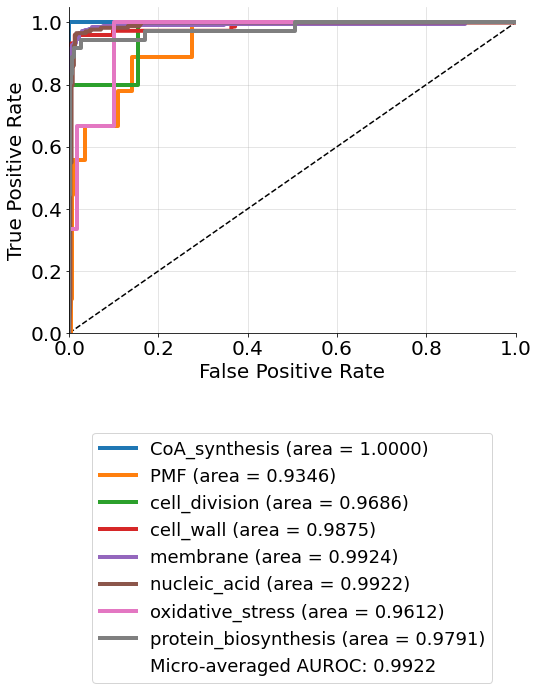

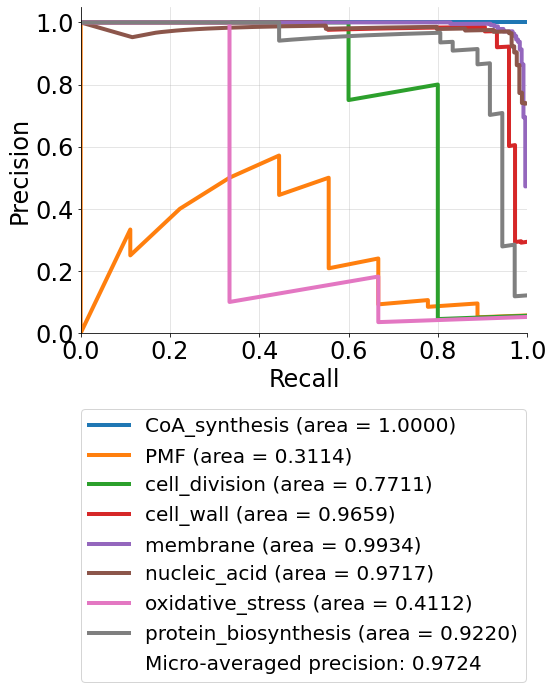

In [148]:
# y_score is the predicted
ordered_labels = holdout_val.iloc[:,1:9].columns.values
y_score = holdout_val.iloc[:,1:9].to_numpy()
# y_OHE is the true label 
chemprop_auc = plot_multiclass_roc('chemprop',y_score,y_OHE,ordered_labels,'')    

In [149]:
# vanilla chemprop model metrics
print('Cohen kappa score:', chemprop_cks)
print('Matthews correlation coefficient:', chemprop_mcc)
print('ROC AUC:', chemprop_auc[0])
print('PRC AUC:', chemprop_auc[1])

Cohen kappa score: 0.9205193311934078
Matthews correlation coefficient: 0.9205728898095171
ROC AUC: {0: 1.0, 1: 0.9346405228758169, 2: 0.9686131386861314, 3: 0.9875444337866051, 4: 0.992406573018818, 5: 0.9921813203529054, 6: 0.9612121212121212, 7: 0.9790995056952503, 9: 0.9921657038381705}
PRC AUC: {0: 1.0, 1: 0.31140715329394575, 2: 0.7711111111111111, 3: 0.9659463920878212, 4: 0.9934469396879556, 5: 0.9717276530319494, 6: 0.4111807732497388, 7: 0.9219620879053867, 9: 0.9724140502295818}


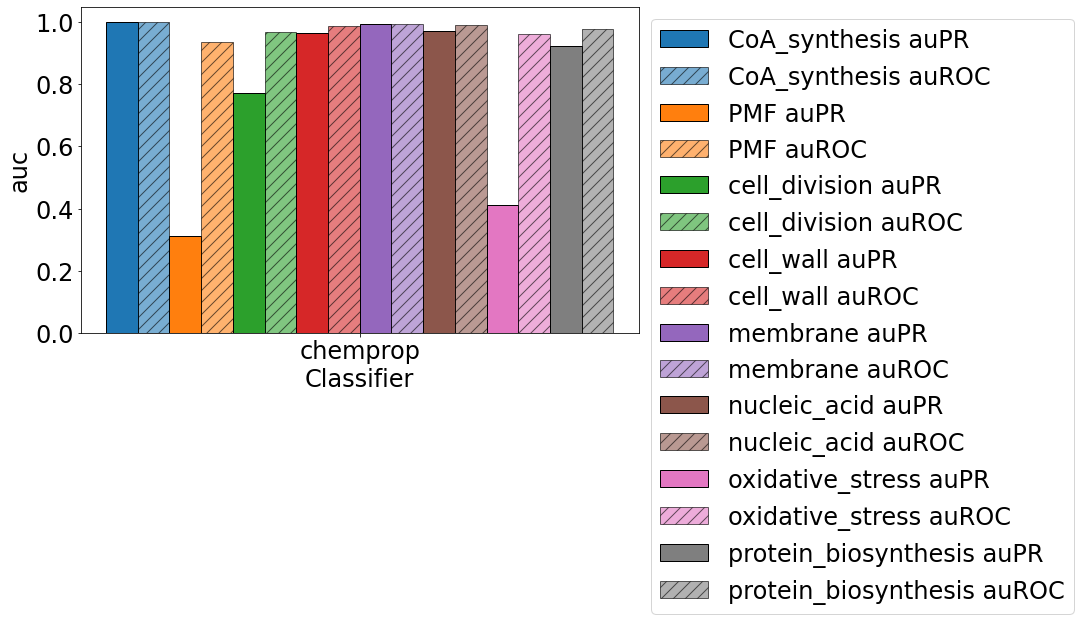

In [150]:
# plotting auROC and auPR for vanilla chemprop
auroc_list = [[chemprop_auc[0]]]
aupr_list = [[chemprop_auc[1]]]
clf_list = ['chemprop']
auroc_aupr_barchart('auc',auroc_list,aupr_list,ordered_labels,clf_list)

# Part 6: Evidential chemprop (must run evidential uncertainty chemprop first using commands in chemprop_script.txt in evidential chemprop env)¶

In [180]:
# loading evidential chemprop predictions
holdout_val = pd.read_csv('../outputs/evidential_chemprop_optimized/holdout_preds.csv')

## important!!! Open holdout_preds.csv in Excel and manually delete the extra last 6 columns or file will read into pandas incorrectly

In [181]:
# halicin test case
holdout_val[holdout_val['smiles'] == 'Nc1nnc(Sc2ncc([N+](=O)[O-])s2)s1']

smiles  CoA_synthesis      PMF  cell_division  \
89  Nc1nnc(Sc2ncc([N+](=O)[O-])s2)s1       0.066727  0.04365       0.038906   

    cell_wall  membrane  nucleic_acid  oxidative_stress  protein_biosynthesis  \
89   0.061459   0.06734       0.90118           0.04095              0.061465   

    true_CoA_synthesis  true_PMF  true_cell_division  true_cell_wall  \
89            0.365301  0.295437            0.278836        0.349954   

    true_membrane  true_nucleic_acid  true_oxidative_stress  \
89       0.366976            0.44434               0.286178   

    true_protein_biosynthesis  uncertainty       std  
89                   0.350474     0.365301  0.295437

In [182]:
# ribocil C test case
holdout_val[holdout_val['smiles'] == 'NCC#Cc1cnc(-n2cnc(CN3CCC[C@H](c4nc(O)cc(-c5cccs5)n4)C3)c2)nc1']

smiles  CoA_synthesis  \
194  NCC#Cc1cnc(-n2cnc(CN3CCC[C@H](c4nc(O)cc(-c5ccc...       0.017844   

          PMF  cell_division  cell_wall  membrane  nucleic_acid  \
194  0.021204       0.017511   0.021947  0.969286       0.02343   

     oxidative_stress  protein_biosynthesis  true_CoA_synthesis  true_PMF  \
194           0.01672              0.023775            0.188914  0.205931   

     true_cell_division  true_cell_wall  true_membrane  true_nucleic_acid  \
194             0.18714         0.20951       0.247847            0.21647   

     true_oxidative_stress  true_protein_biosynthesis  uncertainty       std  
194               0.182864                   0.218059     0.188914  0.205931

In [183]:
# reading labels
holdout_labels = pd.read_csv('../data/chemprop_nonhuman_multilabel_inputs/holdout.csv')
y_OHE = holdout_labels.iloc[:,1:9].to_numpy()
y_true = np.argmax(y_OHE,axis=1)
# len(y_true)

In [184]:
y_pred_OHE = np.argmax(holdout_val.iloc[:,1:9].to_numpy(),axis=1)
# len(y_pred_OHE)

In [185]:
# model metrics
evidential_acc = np.sum(y_pred_OHE == y_true)/y_true.shape[0]
evidential_cks = cohen_kappa_score(y_pred_OHE, y_true)        
evidential_mcc = matthews_corrcoef(y_pred_OHE, y_true)
print('accuracy:', evidential_acc)
print('Cohen kappa score:', evidential_cks)
print('Matthews correlation coefficient:',evidential_mcc)

accuracy: 0.8842676311030742
Cohen kappa score: 0.8293242800100307
Matthews correlation coefficient: 0.832325161500016


In [186]:
# plotting auROC / auPR
def plot_multiclass_roc(type_of_class, y_score, y_test, ordered_labels, type_of_input, figsize=(8, 6)):
    n_classes = len(ordered_labels)
    if type_of_class == 'rfc' or type_of_class == 'gpc' or type_of_class == 'knn':
        y_score = clf.predict_proba(X_test) # this makes gpc work even though it's predicting numeric class
    elif type_of_class == 'svm':
        y_score = clf.decision_function(X_test)
    # structures    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    precision = dict()
    recall = dict()
    prc_auc = dict()
    
    # calculate dummies once
#     y_test = np.vstack(y_test) # pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        prc_auc[i] = average_precision_score(y_test[:, i], y_score[:, i])
    roc_auc[n_classes+1] = roc_auc_score(y_test, y_score, multi_class='ovr', average='micro')
    prc_auc[n_classes+1] = average_precision_score(y_test, y_score, average="micro")
#     roc_auc[n_classes+2] = roc_auc_score(y_test, y_score, multi_class='ovr', average='macro')
    
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    plt.rc('font',size=24)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
#     ax.set_title('Receiver operating characteristic curve')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='%s (area = %0.4f)' % (ordered_labels[i],roc_auc[i]), linewidth=4)
    ax.plot([], [], ' ', label='Micro-averaged AUROC: %0.4f' % roc_auc[n_classes+1])
#     ax.plot([], [], ' ', label='Macro-averaged AUROC: {}'.format(roc_auc[n_classes+2]))
    leg = ax.legend(loc="lower center",fontsize=18)
    # Get the bounding box of the original legend
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

    # Change to location of the legend. 
    xOffset = -1.1
    bb.y0 += xOffset
    bb.y1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


    ax.grid(alpha=.4)
    sns.despine()
    fig.savefig('../outputs/'+type_of_class+'_ROC_multiclass_nonhuman_'+type_of_input+'.png', bbox_inches='tight')
    
    # prc for each class
    fig, ax = plt.subplots(figsize=figsize)
    plt.rc('font',size=24)
#     ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
#     ax.set_title('Precision Recall curve')
    for i in range(n_classes):
        ax.plot(recall[i], precision[i], label='%s (area = %0.4f)' % (ordered_labels[i], prc_auc[i]), linewidth=4)
    ax.plot([], [], ' ', label='Micro-averaged precision: %0.4f' % prc_auc[n_classes+1])
#     ax.plot([], [], ' ', label='Macro-averaged AUROC: {}'.format(roc_auc[n_classes+2]))
    leg = ax.legend(loc="lower center",fontsize=20)
    # Get the bounding box of the original legend
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

    # Change to location of the legend. 
    xOffset = -1.1
    bb.y0 += xOffset
    bb.y1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

    ax.grid(alpha=.4)
    sns.despine()
    fig.savefig('../outputs/'+type_of_class+'_PRC_multiclass_nonhuman_'+type_of_input+'.png', bbox_inches='tight')
    plt.show()
    
    return [roc_auc, prc_auc]

<ipython-input-186-3d8fc1c10e14>:42: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
<ipython-input-186-3d8fc1c10e14>:70: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


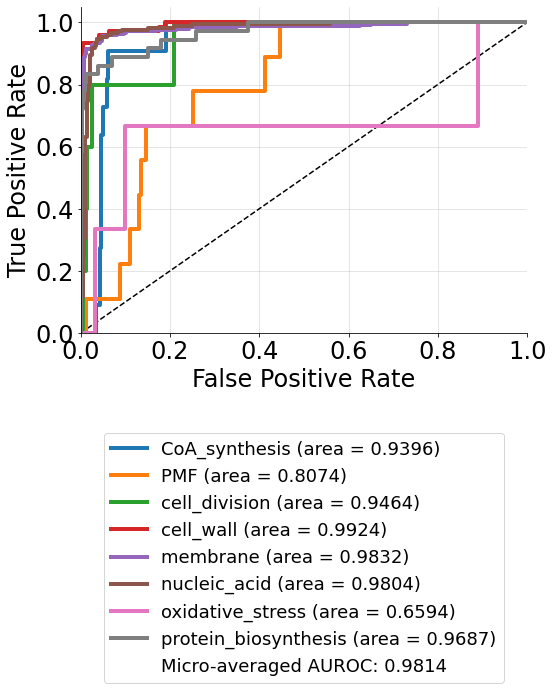

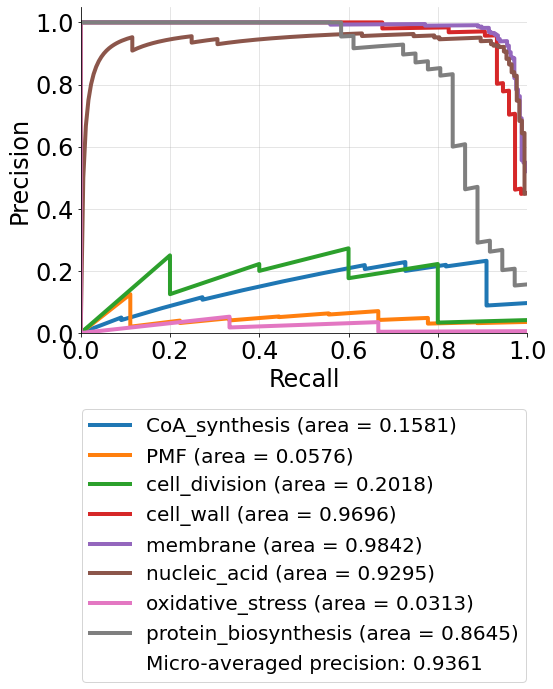

In [188]:
# y_score is the predicted
ordered_labels = holdout_val.iloc[:,1:9].columns.values
y_score = holdout_val.iloc[:,1:9].to_numpy()
# print(y_score.shape)
# print(y_OHE.shape)
# y_OHE is the true label 
evidential_auc = plot_multiclass_roc('evidential_chemprop',y_score,y_OHE,ordered_labels,'')    

In [189]:
print('Cohen kappa score:', evidential_cks)
print('Matthews correlation coefficient:', evidential_mcc)
print('ROC AUC:', evidential_auc[0])
print('PRC AUC:', evidential_auc[1])

Cohen kappa score: 0.8293242800100307
Matthews correlation coefficient: 0.832325161500016
ROC AUC: {0: 0.9396175779939618, 1: 0.8073937908496731, 2: 0.9463503649635037, 3: 0.9923827794391468, 4: 0.9831566392790883, 5: 0.9803620322482507, 6: 0.6593939393939394, 7: 0.9687298517085752, 9: 0.9813782893023739}
PRC AUC: {0: 0.15812851772084124, 1: 0.05762665677034349, 2: 0.20176767676767676, 3: 0.9695786125124198, 4: 0.9841515427715014, 5: 0.9295212453165745, 6: 0.03127228640707459, 7: 0.8645121684065121, 9: 0.9361057178029145}


In [190]:
import matplotlib.colors as mcolors
def auroc_aupr_barchart(plot_type, y1s, y2s, class_list, clf_list, width=0.05):
    colors = list(mcolors.TABLEAU_COLORS)[:len(class_list)]
    # xs: list of offset x values for each class
    xs = [np.arange(len(clf_list))+width*i for i in range(2*len(class_list))]
    fig, ax = plt.subplots(figsize=(10,6))
    
    odd = False
    for class_idx, x in enumerate(xs):
#         if class_idx >= len(class_list):
#             class_idx -= len(class_list)
        if odd:
            class_idx = int((class_idx+1)/2-1)
            heights = [ylist[0][class_idx] for ylist in y1s]
            plt.bar(x=x,height=heights,width=width,label=class_list[class_idx]+' auROC',align='edge',color=colors[class_idx],edgecolor='black',alpha=0.6,hatch='//')
        else:
            class_idx = int(class_idx/2)
            heights = [ylist[0][class_idx] for ylist in y2s]
            plt.bar(x=x,height=heights,width=width,label=class_list[class_idx]+' auPR',align='edge',color=colors[class_idx],edgecolor='black')
        odd = not odd
    plt.xlabel('Classifier')
    plt.ylabel(plot_type)
    plt.xticks([r+width*len(class_list) for r in range(len(clf_list))], clf_list)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.savefig('../outputs/evidential_chemprop_aupr_auroc.png',bbox_inches='tight')

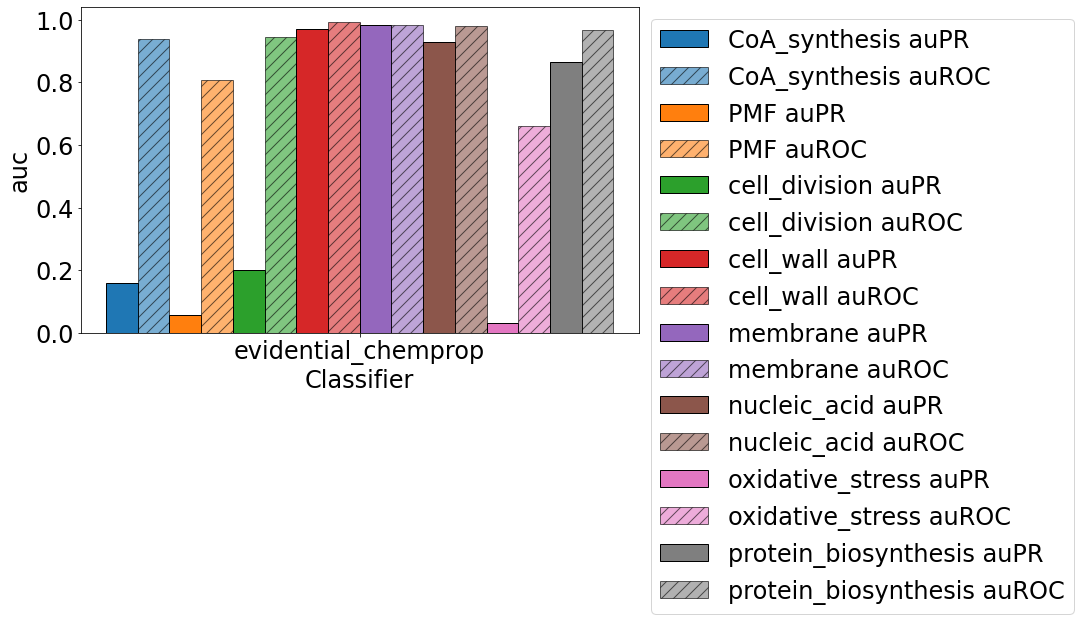

In [191]:
# plot auPR and auROC for evidential chemprop
auroc_list = [[evidential_auc[0]]]
aupr_list = [[evidential_auc[1]]]
clf_list = ['evidential_chemprop']
auroc_aupr_barchart('auc',auroc_list,aupr_list,ordered_labels,clf_list)

In [192]:
# displaying evidential chemprop predictions with uncertainty
chemprop_preds = pd.read_csv('../outputs/evidential_chemprop_optimized/external_val_preds.csv')
chemprop_val = pd.read_csv('../data/chemprop_nonhuman_multilabel_inputs/external_val.csv')
chemprop_preds

smiles  CoA_synthesis  \
0   CC[C@H](C)[C@H](NC(=O)[C@H](CCCN)NC(=O)CNC(=O)...       0.034321   
1   CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...       0.035545   
2   CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...       0.035550   
3   CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)C...       0.034944   
4   CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)C...       0.035158   
5          CC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21       0.044899   
6   CN(C)CCc1ccc(-c2cc(-c3ccc4c(c3)CC/C4=N\O)c(-c3...       0.056686   
7                     c1cc2ccc(N3CCNCC3)cc2c(C2CC2)n1       0.059153   
8                  CCn1cc(C(=O)O)c(=O)cc1/C=C/c1ccsc1       0.043094   
9                Clc1cccc(Cl)c1CCc1cc(C2CCNCC2)[nH]n1       0.066349   
10  Oc1cc(-c2cccs2)nc([C@H]2CCCN(Cc3cn(-c4ncccn4)c...       0.075211   
11  NCc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)n4)C...       0.073432   
12  CNCc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)n4)...       0.073557   
13  CN(C)Cc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)...       0.064628   
14  NCCCc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)n4...       0.070119   
15                                        C1=NC=N[N]1       0.049350   
16                         Cc1ccc(/C=C/C(=O)NC(C)C)o1       0.028817   
17                            N#Cc1ccccc1CSc1nc[nH]n1       0.062595   
18                            C#CCCNC(=O)/C=C/c1ccco1       0.022876   
19                              NS(=O)(=O)C#Cc1ccccc1       0.004818   
20                              CCCCCCCCCOc1cccc(N)c1       0.061860   
21                 CS(=O)(=O)N[C@H](Cc1ccccc1)C(=O)NO       0.017968   
22                               NC(CC(=O)NO)c1ccccc1       0.028574   
23                             CCCCCCCCCOc1cccc(CN)c1       0.056055   
24              CS(=O)(=O)N[C@H](Cc1ccc(O)cc1)C(=O)NO       0.019451   
25        O=c1c2ccccc2nc(/C=C/c2ccccc2)n1-c1cccc(O)c1       0.046429   
26     Cc1ccc(/C=C/c2nc3ccccc3c(=O)n2-c2cccc(O)c2)cc1       0.045628   
27     O=c1c2cnccc2nc(/C=C/c2ccc(F)cc2)n1-c1cccc(O)c1       0.044663   
28        O=c1c2ccccc2nc(/C=C/c2ccncc2)n1-c1cccc(O)c1       0.047638   
29   N#Cc1ccc(/C=C/c2nc3ccncc3c(=O)n2-c2cccc(O)c2)cc1       0.044844   
30                 CCCCCCc1ccc(-c2cn(C(C)C)c(N)n2)cc1       0.055032   
31                    CCCCCCc1ccc(-c2cn(CC)c(N)n2)cc1       0.057722   
32      CCCCCCCCCC1C/C(=N\OCc2ccccc2)c2c(O)cc(O)cc2O1       0.050563   
33                     CCCC1C/C(=N\O)c2c(O)cc(O)cc2O1       0.056513   
34              CCCCCCCCCC1C/C(=N\OC)c2c(O)cc(O)cc2O1       0.058108   
35               CCCCCCCCCC1C/C(=N\O)c2c(O)cc(O)cc2O1       0.057010   
36                 CCCCCCCC1C/C(=N\O)c2c(O)cc(O)cc2O1       0.057973   
37             Cc1nccn1CCC(=O)N/N=C/c1c(O)ccc2ccccc12       0.025284   
38          Cc1nc2ccccc2n1CCC(=O)N/N=C/c1cccc2ccccc12       0.033669   
39      Cc1nc2ccccc2n1CCCC(=O)N/N=C/c1c(O)ccc2ccccc12       0.029077   
40               Cc1nc2ccccc2n1CCC(=O)N/N=C/c1ccccc1O       0.028645   
41       Cc1nc2ccccc2n1CCC(=O)N/N=C/c1c(O)ccc2ccccc12       0.027208   
42                      C[n+]1ccc(-c2cc[n+](C)cc2)cc1       0.046629   
43           COS(=O)(=O)[O-].C[n+]1c2ccccc2nc2ccccc21       0.053574   
44                         Cn1c2cccc(=O)c-2nc2ccccc21       0.050061   
45  CC(=CC(=O)OCCCCCCCCC(=O)O)CC1OCC(CC2OC2C(C)C(C...       0.025958   
46                   CCCCCNC(=O)CCNC(=O)C(O)C(C)(C)CO       0.029089   
47                 CCC(CCCCCCCCCCc1cc(O)cc(O)c1)C(C)C       0.049294   
48                 CC(C)CCCCCCCCCCCCCCCc1cc(O)cc(O)c1       0.052534   
49           O=C(CCc1ccccc1)NC(=S)Nc1ccc(N2CCCCC2)cc1       0.056549   
50        CC1=CC=C(C(=O)Nc2ccc([N+](=O)O)cc2)S1(=O)=O       0.041139   

         PMF  cell_division  cell_wall  membrane  nucleic_acid  \
0   0.041376       0.029345   0.281590  0.063423      0.045900   
1   0.042114       0.029990   0.324938  0.062184      0.048502   
2   0.042013       0.029968   0.340782  0.062346      0.048427   
3   0.041790       0.029706   0.275532

In [193]:
# diplaying evidential chemprop predictions when softmaxing over probabilities
y = chemprop_preds.iloc[:,1:9].to_numpy()
ordinal_preds = np.argmax(y, axis=1)
headers = chemprop_preds.iloc[:,1:9].columns.values
preds = [headers[idx] for idx in ordinal_preds]
chemprop_val['evidential_chemprop_preds'] = preds
chemprop_val['max_tanimoto'] = test_df['max_tanimotos'].to_list()
chemprop_val.iloc[30:].head(10)

smiles                label  \
30             CCCCCCc1ccc(-c2cn(C(C)C)c(N)n2)cc1  membrane, cell wall   
31                CCCCCCc1ccc(-c2cn(CC)c(N)n2)cc1  membrane, cell wall   
32  CCCCCCCCCC1C/C(=N\OCc2ccccc2)c2c(O)cc(O)cc2O1    PMF, nucleic acid   
33                 CCCC1C/C(=N\O)c2c(O)cc(O)cc2O1    PMF, nucleic acid   
34          CCCCCCCCCC1C/C(=N\OC)c2c(O)cc(O)cc2O1    PMF, nucleic acid   
35           CCCCCCCCCC1C/C(=N\O)c2c(O)cc(O)cc2O1    PMF, nucleic acid   
36             CCCCCCCC1C/C(=N\O)c2c(O)cc(O)cc2O1    PMF, nucleic acid   
37         Cc1nccn1CCC(=O)N/N=C/c1c(O)ccc2ccccc12        cell division   
38      Cc1nc2ccccc2n1CCC(=O)N/N=C/c1cccc2ccccc12        cell division   
39  Cc1nc2ccccc2n1CCCC(=O)N/N=C/c1c(O)ccc2ccccc12        cell division   

   evidential_chemprop_preds  max_tanimoto  
30              nucleic_acid      0.479791  
31              nucleic_acid      0.493861  
32                  membrane      0.550107  
33      protein_biosynthesis      0.564311  
34              nucleic_acid      0.571749  
35              nucleic_acid      0.586127  
36              nucleic_acid      0.586127  
37                  membrane      0.365262  
38                  membrane      0.408397  
39                  membrane      0.412338

# Part 7: Feedforward neural network on ECFP4

In [194]:
# reading in feedforward neural network results
holdout_val = pd.read_csv('../outputs/FFN_ECFP4/holdout_preds.csv')
# halicin test case (selected due to unusual MOA)
holdout_val[holdout_val['smiles'] == 'Nc1nnc(Sc2ncc([N+](=O)[O-])s2)s1']

smiles  CoA_synthesis       PMF  cell_division  \
89  Nc1nnc(Sc2ncc([N+](=O)[O-])s2)s1        0.00047  0.006942       0.001277   

    cell_wall  membrane  nucleic_acid  oxidative_stress  protein_biosynthesis  
89   0.009854  0.009288      0.087698           0.00035              0.001743

In [195]:
# ribocil C test case
holdout_val[holdout_val['smiles'] == 'NCC#Cc1cnc(-n2cnc(CN3CCC[C@H](c4nc(O)cc(-c5cccs5)n4)C3)c2)nc1']

smiles  CoA_synthesis  \
194  NCC#Cc1cnc(-n2cnc(CN3CCC[C@H](c4nc(O)cc(-c5ccc...       0.005205   

          PMF  cell_division  cell_wall  membrane  nucleic_acid  \
194  0.000924       0.016488   0.022557  0.018146      0.002805   

     oxidative_stress  protein_biosynthesis  
194          0.001181              0.002666

In [196]:
# process FFN predictions
holdout_labels = pd.read_csv('../data/chemprop_nonhuman_multilabel_inputs/holdout.csv')
y_OHE = holdout_labels.iloc[:,1:9].to_numpy()
y_true = np.argmax(y_OHE,axis=1)
y_pred_OHE = np.argmax(holdout_val.iloc[:,1:9].to_numpy(),axis=1)

In [197]:
# calculating test set metrics
ffn_acc = np.sum(y_pred_OHE == y_true)/y_true.shape[0]
ffn_cks = cohen_kappa_score(y_pred_OHE, y_true)        
ffn_mcc = matthews_corrcoef(y_pred_OHE, y_true)
print('accuracy:', ffn_acc)
print('Cohen kappa score:', ffn_cks)
print('Matthews correlation coefficient:', ffn_mcc)

accuracy: 0.9475587703435805
Cohen kappa score: 0.9231189625829958
Matthews correlation coefficient: 0.9232548768644342


<ipython-input-186-3d8fc1c10e14>:42: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
<ipython-input-186-3d8fc1c10e14>:70: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


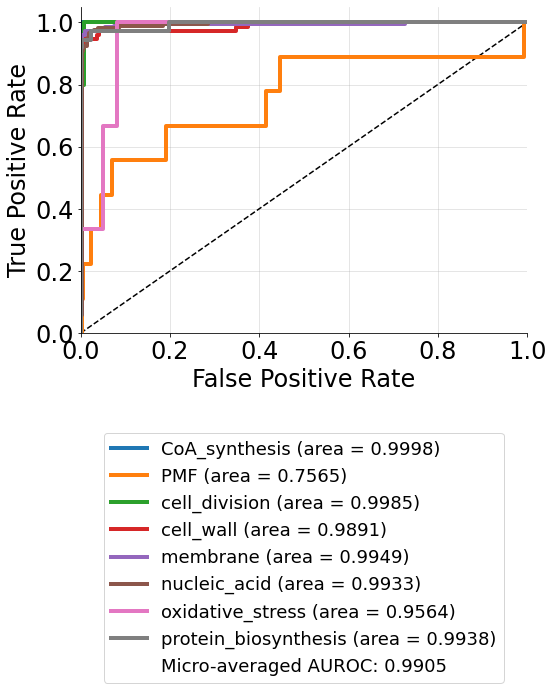

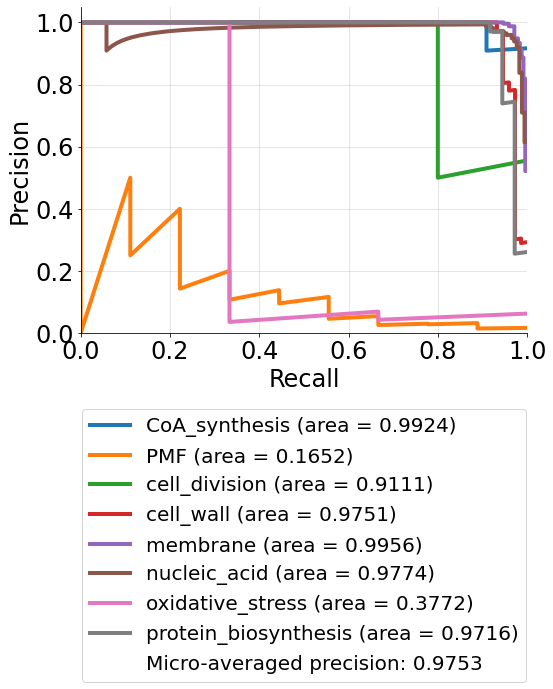

In [198]:
# plotting ROC and PR curves
ordered_labels = holdout_val.iloc[:,1:9].columns.values
y_score = holdout_val.iloc[:,1:9].to_numpy()
# print(y_score.shape)
# print(y_OHE.shape)
# y_OHE is the true label 
ffn_auc = plot_multiclass_roc('FFN_ECFP4',y_score,y_OHE,ordered_labels,'')    

In [199]:
print('Cohen kappa score:', ffn_cks)
print('Matthews correlation coefficient:', ffn_mcc)
print('ROC AUC:', ffn_auc[0])
print('PRC AUC:', ffn_auc[1])

Cohen kappa score: 0.9231189625829958
Matthews correlation coefficient: 0.9232548768644342
ROC AUC: {0: 0.9998322710499832, 1: 0.7565359477124183, 2: 0.9985401459854014, 3: 0.9891384077187836, 4: 0.9948714550755366, 5: 0.9933069668390629, 6: 0.9563636363636364, 7: 0.9938211906297013, 9: 0.9904633945377308}
PRC AUC: {0: 0.9924242424242424, 1: 0.16522938109263344, 2: 0.9111111111111112, 3: 0.9751122416883288, 4: 0.995600490399144, 5: 0.9773604330581867, 6: 0.3771551724137931, 7: 0.9715827496586054, 9: 0.9752593915599767}


In [200]:
import matplotlib.colors as mcolors
def auroc_aupr_barchart(plot_type, y1s, y2s, class_list, clf_list, width=0.05):
    colors = list(mcolors.TABLEAU_COLORS)[:len(class_list)]
    # xs: list of offset x values for each class
    xs = [np.arange(len(clf_list))+width*i for i in range(2*len(class_list))]
    fig, ax = plt.subplots(figsize=(10,6))
    
    odd = False
    for class_idx, x in enumerate(xs):
#         if class_idx >= len(class_list):
#             class_idx -= len(class_list)
        if odd:
            class_idx = int((class_idx+1)/2-1)
            heights = [ylist[0][class_idx] for ylist in y1s]
            plt.bar(x=x,height=heights,width=width,label=class_list[class_idx]+' auROC',align='edge',color=colors[class_idx],edgecolor='black',alpha=0.6,hatch='//')
        else:
            class_idx = int(class_idx/2)
            heights = [ylist[0][class_idx] for ylist in y2s]
            plt.bar(x=x,height=heights,width=width,label=class_list[class_idx]+' auPR',align='edge',color=colors[class_idx],edgecolor='black')
        odd = not odd
    plt.xlabel('Classifier')
    plt.ylabel(plot_type)
    plt.xticks([r+width*len(class_list) for r in range(len(clf_list))], clf_list)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.savefig('../outputs/FFN_ECFP4_aupr_auroc.png',bbox_inches='tight')

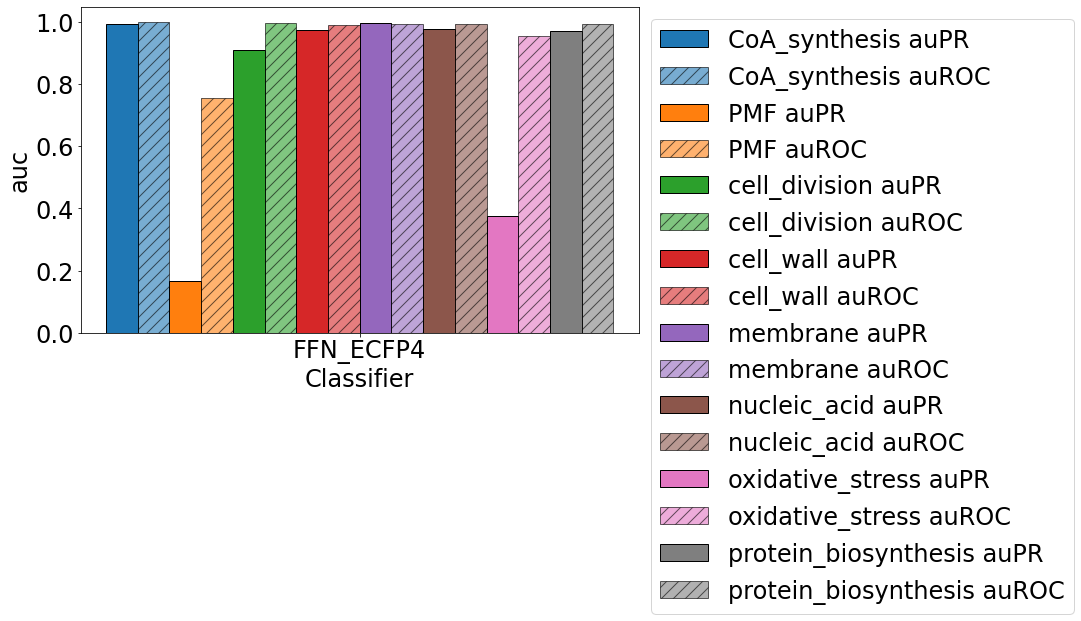

In [201]:
# plotting auroc and aupr
auroc_list = [[ffn_auc[0]]]
aupr_list = [[ffn_auc[1]]]
clf_list = ['FFN_ECFP4']
auroc_aupr_barchart('auc',auroc_list,aupr_list,ordered_labels,clf_list)

In [202]:
# display probabilities from FFN prediction
FFN_preds = pd.read_csv('../outputs/FFN_ECFP4/external_val_preds.csv')
FFN_val = pd.read_csv('../data/chemprop_nonhuman_multilabel_inputs/external_val.csv')
FFN_preds

smiles  CoA_synthesis  \
0       CCCCCCCCCC1C/C(=N\OCc2ccccc2)c2c(O)cc(O)cc2O1       0.001683   
1                      CCCC1C/C(=N\O)c2c(O)cc(O)cc2O1       0.000381   
2               CCCCCCCCCC1C/C(=N\OC)c2c(O)cc(O)cc2O1       0.001510   
3                CCCCCCCCCC1C/C(=N\O)c2c(O)cc(O)cc2O1       0.000185   
4                  CCCCCCCC1C/C(=N\O)c2c(O)cc(O)cc2O1       0.000185   
5                               CCCCCCCCCOc1cccc(N)c1       0.001274   
6                  CS(=O)(=O)N[C@H](Cc1ccccc1)C(=O)NO       0.000259   
7                                NC(CC(=O)NO)c1ccccc1       0.003691   
8                              CCCCCCCCCOc1cccc(CN)c1       0.001646   
9               CS(=O)(=O)N[C@H](Cc1ccc(O)cc1)C(=O)NO       0.000398   
10        O=c1c2ccccc2nc(/C=C/c2ccccc2)n1-c1cccc(O)c1       0.002370   
11     Cc1ccc(/C=C/c2nc3ccccc3c(=O)n2-c2cccc(O)c2)cc1       0.001625   
12     O=c1c2cnccc2nc(/C=C/c2ccc(F)cc2)n1-c1cccc(O)c1       0.000722   
13        O=c1c2ccccc2nc(/C=C/c2ccncc2)n1-c1cccc(O)c1       0.002041   
14   N#Cc1ccc(/C=C/c2nc3ccncc3c(=O)n2-c2cccc(O)c2)cc1       0.001242   
15  CC[C@H](C)[C@H](NC(=O)[C@H](CCCN)NC(=O)CNC(=O)...       0.000004   
16  CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...       0.000002   
17  CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...       0.000002   
18  CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)C...       0.000002   
19  CC[C@H](C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)C...       0.000004   
20  Oc1cc(-c2cccs2)nc([C@H]2CCCN(Cc3cn(-c4ncccn4)c...       0.001497   
21  NCc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)n4)C...       0.002540   
22  CNCc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)n4)...       0.002332   
23  CN(C)Cc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)...       0.001335   
24  NCCCc1cnc(-n2cnc(CN3CCCC(c4nc(O)cc(-c5cccs5)n4...       0.002408   
25                                        C1=NC=N[N]1       0.000546   
26                         Cc1ccc(/C=C/C(=O)NC(C)C)o1       0.001603   
27                            N#Cc1ccccc1CSc1nc[nH]n1       0.001289   
28                            C#CCCNC(=O)/C=C/c1ccco1       0.000475   
29                              NS(=O)(=O)C#Cc1ccccc1       0.001735   
30         CC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21       0.000209   
31  CN(C)CCc1ccc(-c2cc(-c3ccc4c(c3)CC/C4=N\O)c(-c3...       0.000436   
32                    c1cc2ccc(N3CCNCC3)cc2c(C2CC2)n1       0.000212   
33                 CCn1cc(C(=O)O)c(=O)cc1/C=C/c1ccsc1       0.002078   
34               Clc1cccc(Cl)c1CCc1cc(C2CCNCC2)[nH]n1       0.000769   
35             Cc1nccn1CCC(=O)N/N=C/c1c(O)ccc2ccccc12       0.000196   
36          Cc1nc2ccccc2n1CCC(=O)N/N=C/c1cccc2ccccc12       0.002500   
37      Cc1nc2ccccc2n1CCCC(=O)N/N=C/c1c(O)ccc2ccccc12       0.001000   
38               Cc1nc2ccccc2n1CCC(=O)N/N=C/c1ccccc1O       0.000782   
39       Cc1nc2ccccc2n1CCC(=O)N/N=C/c1c(O)ccc2ccccc12       0.000748   
40                 CCCCCCc1ccc(-c2cn(C(C)C)c(N)n2)cc1       0.000365   
41                    CCCCCCc1ccc(-c2cn(CC)c(N)n2)cc1       0.000919   
42                      C[n+]1ccc(-c2cc[n+](C)cc2)cc1       0.000570   
43           COS(=O)(=O)[O-].C[n+]1c2ccccc2nc2ccccc21       0.000513   
44                         Cn1c2cccc(=O)c-2nc2ccccc21       0.000153   
45  CC(=CC(=O)OCCCCCCCCC(=O)O)CC1OCC(CC2OC2C(C)C(C...       0.000037   
46                   CCCCCNC(=O)CCNC(=O)C(O)C(C)(C)CO       0.001017   
47                 CCC(CCCCCCCCCCc1cc(O)cc(O)c1)C(C)C       0.002685   
48                 CC(C)CCCCCCCCCCCCCCCc1cc(O)cc(O)c1       0.001325   
49           O=C(CCc1ccccc1)NC(=S)Nc1ccc(N2CCCCC2)cc1       0.001100   
50        CC1=CC=C(C(=O)Nc2ccc([N+](=O)O)cc2)S1(=O)=O       0.000140   

         PMF  cell_division  cell_wall  membrane  nucleic_acid  \
0   0.001018   2.352556e-02   0.008170  0.210966  1.099678e-01   
1   0.004881   1.350533e-02   0.004202  0.069674  8.696672e-01   
2   0.001388   2.577768e-02   0.002088  0.010993  7.314236e-01   
3   0.004718   3.650438e-03   0.007818

In [203]:
# display FFN classifications
y = FFN_preds.iloc[:,1:9].to_numpy()
ordinal_preds = np.argmax(y, axis=1)
headers = FFN_preds.iloc[:,1:9].columns.values
preds = [headers[idx] for idx in ordinal_preds]
FFN_val['FFN_ECFP4_preds'] = preds
FFN_val.iloc[40:].head(11)

smiles             label  \
40               Cc1nc2ccccc2n1CCC(=O)N/N=C/c1ccccc1O     cell division   
41       Cc1nc2ccccc2n1CCC(=O)N/N=C/c1c(O)ccc2ccccc12     cell division   
42                      C[n+]1ccc(-c2cc[n+](C)cc2)cc1  oxidative stress   
43           COS(=O)(=O)[O-].C[n+]1c2ccccc2nc2ccccc21  oxidative stress   
44                         Cn1c2cccc(=O)c-2nc2ccccc21  oxidative stress   
45  CC(=CC(=O)OCCCCCCCCC(=O)O)CC1OCC(CC2OC2C(C)C(C...  oxidative stress   
46                   CCCCCNC(=O)CCNC(=O)C(O)C(C)(C)CO     CoA synthesis   
47                 CCC(CCCCCCCCCCc1cc(O)cc(O)c1)C(C)C     CoA synthesis   
48                 CC(C)CCCCCCCCCCCCCCCc1cc(O)cc(O)c1     CoA synthesis   
49           O=C(CCc1ccccc1)NC(=S)Nc1ccc(N2CCCCC2)cc1     CoA synthesis   
50        CC1=CC=C(C(=O)Nc2ccc([N+](=O)O)cc2)S1(=O)=O     CoA synthesis   

     FFN_ECFP4_preds  
40          membrane  
41          membrane  
42          membrane  
43      nucleic_acid  
44  oxidative_stress  
45  oxidative_stress  
46          membrane  
47         cell_wall  
48         cell_wall  
49         cell_wall  
50      nucleic_acid

# Part 7: Comparing deep models

In [204]:
import matplotlib.colors as mcolors
def auroc_aupr_dot_barchart(plot_type, y1s, y2s, class_list, clf_names, width=0.05):
    '''
    dots are values for each class
    bar is micro-average of classes; class imbalance makes averages very high
    '''
    clf_list = clf_names
    colors = list(mcolors.TABLEAU_COLORS)[:2]
    # xs: list of offset x values for each class
    xs = [np.arange(len(clf_list))+width*i for i in range(2)]
    fig, ax = plt.subplots(figsize=(10,6))
    n_classes = len(class_list)
    
    ys = [y1s, y2s]
    for idx, x in enumerate(xs):
        heights = [y[n_classes+1] for y in ys[idx]]
        plt.bar(x=x,height=heights,width=width,label=['auROC','auPR'][idx],align='edge',color=colors[idx],edgecolor='black',alpha=0.6,hatch='')    
        for class_idx in range(n_classes):    
            plt.plot([xi+width*len(clf_list)/(2*len(clf_list)) for xi in x],[ys[idx][clf_idx][class_idx] for clf_idx in range(len(clf_names))],marker='.',linestyle='',color='black')
    plt.rc('font', size=20) 
    plt.xlabel('Classifier')
    plt.ylabel(plot_type)
    plt.xticks([r+width*len(clf_list)/(len(clf_list)) for r in range(len(clf_list))], clf_names)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.savefig('../outputs/deep_models_aupr_auroc_slides.png',bbox_inches='tight')
    
def multiclass_metrics_barchart(plot_type, y1s, y2s, y3s, clf_names, width=0.05):
    clf_list = clf_names
    colors = list(mcolors.TABLEAU_COLORS)[:3]
    # xs: list of offset x values for each class
    xs = [np.arange(len(clf_list))+width*i for i in range(3)]
    fig, ax = plt.subplots(figsize=(10,6))
    
    ys = [y1s, y2s, y3s]
    for idx, y in enumerate(ys):
        heights = [y[type_of_class] for type_of_class in clf_names]
        plt.bar(x=xs[idx],height=heights,width=width,label=['Test Accuracy','Cohen Kappa Score','Matthews Correlation'][idx],align='edge',color=colors[idx],edgecolor='black',alpha=0.6,hatch='')
    plt.xlabel('Classifier')
    plt.ylabel(plot_type)
    plt.xticks([r+width*len(clf_list)/2 for r in range(len(clf_list))], clf_names)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.rc('font', size=20) 
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.savefig('../outputs/deep_models_metrics_slides.png',bbox_inches='tight')

In [205]:
# creating inputs to making plots
auroc_list = [ffn_auc[0], chemprop_auc[0], evidential_auc[0]]
aupr_list = [ffn_auc[1], chemprop_auc[1], evidential_auc[1]]
clf_names = ['FFN', 'Chemprop', 'Uncertainty\nChemprop']
acc_list = [ffn_acc, chemprop_acc, evidential_acc]
cks_list = [ffn_cks, chemprop_cks, evidential_cks]
mcc_list = [ffn_mcc, chemprop_mcc, evidential_mcc]
acc_dict = {clf_names[i]:acc_list[i] for i in range(len(clf_names))}
cks_dict = {clf_names[i]:cks_list[i] for i in range(len(clf_names))}
mcc_dict = {clf_names[i]:mcc_list[i] for i in range(len(clf_names))}
class_list = ['nucleic acid','cell division','cell wall','CoA synthesis','protein biosynthesis','membrane','oxidative stress', 'PMF']

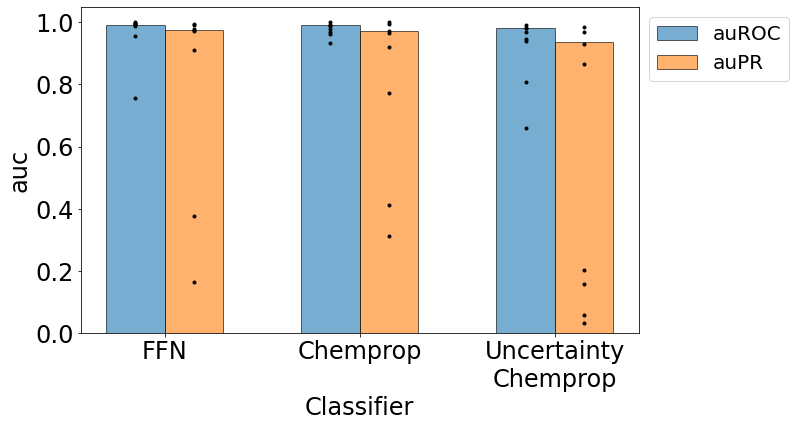

In [206]:
# displaying auPR and auROC for all three deep models
auroc_aupr_dot_barchart('auc', auroc_list, aupr_list, class_list, clf_names, width=0.3)

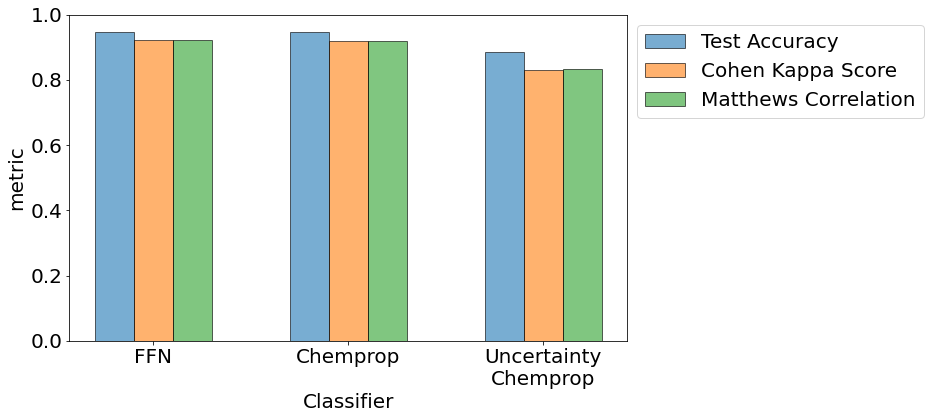

In [207]:
multiclass_metrics_barchart('metric', acc_dict, cks_dict, mcc_dict, clf_names, width=0.2)

# Part 9: Chemprop on Brochado

Brochado et al. was not a good external validation set since not all classes were represented and the most dissimilar compounds were human drugs, which did not have trustworthy ground-truth labels.

In [208]:
brochado_val = pd.read_csv('../outputs/chemprop_nonhuman_multilabel_classification_1_fold/brochado_val_preds.csv')

In [211]:
y = brochado_val.iloc[:,2:10].to_numpy()
ordinal_preds = np.argmax(y, axis=1)
# print(ordinal_preds)
headers = brochado_val.iloc[:,2:10].columns.values
# print(headers)
preds = [headers[idx] for idx in ordinal_preds]
brochado_val['preds'] = preds
brochado_df = labeled_drugs.copy()
brochado_mask = [label == 'brochados' for label in brochado_df.hold_out]
brochado_df = brochado_df[brochado_mask]
brochado_val['compound'] = brochado_df.Compound.to_list()

In [212]:
brochado_val.iloc[0:].head(20)

smiles                labels  \
0   NCCC(O)C(=O)NC1CC(N)C(OC2OC(CN)C(O)C(O)C2O)C(O...  protein biosynthesis   
1   CNC(C)C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC...  protein biosynthesis   
2   NCC1OC(OC2C(N)CC(N)C(OC3OC(CO)C(O)C(N)C3O)C2O)...  protein biosynthesis   
3          CC(=O)NCC1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1  protein biosynthesis   
4      CC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccccc3)C2SC1             cell wall   
5                                          NC1CONC1=O             cell wall   
6   CCCC1CC(C(=O)NC(C(C)Cl)C2OC(SC)C(O)C(O)C2O)N(C)C1  protein biosynthesis   
7    CC1(C)SC2C(NC(=O)C(N)c3ccc(O)cc3)C(=O)N2C1C(=O)O             cell wall   
8   Cc1onc(-c2ccccc2)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2...             cell wall   
9   CON=C(C(=O)NC1C(=O)N2C(C(=O)O)=C(COC(C)=O)CSC1...             cell wall   
10    NC(C(=O)NC1C(=O)N2C(C(=O)O)=C(Cl)CSC12)c1ccccc1             cell wall   
11  NC(=O)c1cc[n+](CC2=C(C(=O)[O-])N3C(=O)C(NC(=O)...             cell wall   
12  CCN1CCN(C(=O)NC(C(=O)NC2C(=O)N3C2SC(C)(C)C3C(=...             cell wall   
13         CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O             cell wall   
14             CC(O)C1C(=O)N2C(C(=O)O)=C(SCCN=CN)CC12             cell wall   
15            CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O             cell wall   
16  CC1C(NC(=O)C(=NOC(C)(C)C(=O)O)c2csc(N)n2)C(=O)...             cell wall   
17  Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OCC2OC(n...             cell wall   
18  CCCCCCCCCC(=O)NC1C(Oc2c3cc4cc2Oc2ccc(cc2Cl)C(O...             cell wall   
19  CCC(C)C(N)C1=NCC(C(=O)NC(CC(C)C)C(=O)NC(CCC(=O...             cell wall   

    CoA_synthesis           PMF  cell_division     cell_wall      membrane  \
0    4.373648e-15  5.935095e-09   4.763044e-14  1.537455e-10  2.175919e-10   
1    2.804149e-17  1.612261e-09   2.395408e-16  2.732258e-12  5.090392e-13   
2    5.704770e-22  5.100226e-13   8.264599e-21  2.486389e-15  1.997465e-16   
3    5.767936e-10  1.509825e-04   2.489904e-09  9.853999e-07  8.997291e-07   
4    3.649619e-14  9.477309e-13   3.083077e-20  1.000000e+00  7.134859e-15   
5    2.731000e-10  1.577483e-05   9.657909e-10  3.704956e-07  2.269716e-07   
6    3.830186e-10  2.697516e-05   1.816452e-09  6.852370e-07  4.711987e-07   
7    4.544534e-12  8.728468e-11   2.510423e-17  1.000000e+00  8.853998e-13   
8    9.044723e-10  2.684756e-09   2.223216e-14  1.000000e+00  5.588479e-11   
9    9.204384e-13  1.730335e-11   3.935356e-18  1.000000e+00  3.728005e-13   
10   5.269874e-15  1.794029e-13   2.288885e-21  1.000000e+00  1.310200e-15   
11   1.432307e-13  1.010819e-11   3.140926e-19  1.000000e+00  2.647553e-13   
12   2.136027e-11  3.929956e-10   5.114322e-17  1.000000e+00  6.026687e-12   
13   1.991747e-12  5.434576e-11   4.286512e-18  1.000000e+00  8.857833e-13   
14   1.253076e-08  1.004329e-06   2.074103e-11  9.999999e-01  3.960820e-08   
15   2.274014e-11  3.823341e-09   3.931083e-16  1.000000e+00  2.262459e-11   
16   3.686091e-09  4.510632e-07   2.569452e-12  9.999999e-01  1.494823e-08   
17   5.687983e-11  1.327609e-09   2.921401e-15  1.000000e+00  6.631876e-11   
18   1.915166e-05  3.061126e-04   2.036099e-07  9.999233e-01  1.808499e-05   
19   1.657697e-03  7.674218e-01   6.161057e-04  6.173448e-02  2.190420e-01   

    nucleic_acid  oxidative_stress  protein_biosynthesis  \
0   1.552790e-07      4.991955e-06          9.999999e-01   
1   7.431883e-06      4.689446e-08          9.999998e-01   
2   2.467397e-08      4.440111e-10          1.000000e+00   
3   9.905359e-05      1.840578e-04          9.998268e-01   
4   1.906973e-12      2.267657e-18          1.682563e-13   
5   1.924545e-04      6.154957e-05          9.999326e-01   
6   1.681486e-05      3.865354e-04          9.999453e-01   
7   8.801290e-11      1.069146e-15          1.244945e-11   
8   1.440892e-08      2.075684e-13          5.182419e-10   
9   4.723876e-11      2.013085e-16          3.226930e-12   
10  2.537057e-13      2.640993e-19          3.057531e-14   
11  6.689550e-12      3.1160

# Part 10: Analyzing ML model predictions on least similar Brochado compounds

In [233]:
# load least similar Brochado compounds
least_similar_smiles = pd.read_csv('../data/brochado_generalization_test.csv')
idxs = least_similar_smiles['idxs'].to_list()

# refitting one hot encoder to training data
k=10
training_mask = [label != 'brochados' for label in labeled_drugs['hold_out']]
training_df = labeled_drugs[training_mask]
one = OneHotEncoder()
df = training_df['labels'].to_frame()
OHE_df = one.fit(df)

# regenerating the brochados compounds in the correct order to access k least similar by np.argsort idxs
brochados_df = labeled_drugs.copy()
brochados_mask = [label == 'brochados' for label in brochados_df['hold_out']] 
brochados_df = brochados_df[brochados_mask]
nonhuman_mask = [label != 'human' for label in brochados_df['labels']]
brochados_labels = brochados_df.loc[nonhuman_mask,'labels'].to_list()
test_df = least_similar_smiles.copy()

OHE_df = one.transform(pd.DataFrame(brochados_labels))
OHE_labels = [OHE_df.iloc[i] for i in range(len(OHE_df)) if i>0]
ytrue = [OHE_labels[idx] for idx in idxs[:k]]
# for y in ytrue:
#     print(one.inverse_transform(y.reshape(1,-1)))

In [237]:
# loading trained classifiers
gpc_morgan = load('../outputs/gpc_multiclass_all_morgan.joblib')
gpc_combo = load('../outputs/gpc_multiclass_all.joblib')
rfc_morgan = load('../outputs/rfc_multiclass_all_morgan.joblib')
rfc_combo = load('../outputs/rfc_multiclass_all.joblib')
svm_morgan = load('../outputs/svm_multiclass_all_morgan.joblib')
svm_combo = load('../outputs/svm_multiclass_all.joblib')
knn_morgan = load('../outputs/knn_multiclass_all_morgan.joblib')
knn_combo = load('../outputs/knn_multiclass_all.joblib')
combo_clfs = [rfc_combo, svm_combo, gpc_combo, knn_combo]
morgan_clfs = [rfc_morgan, svm_morgan, gpc_morgan, knn_morgan]

In [238]:
# get rdkit props for all
# below are chemprop features; need to re-generate chemprop features
props = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v','EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2','EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6','EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt','FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3','FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt','Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex','MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge','MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex','MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount',  'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles','NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles','NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms','NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles','NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons','PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5','PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount','SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5','SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4','SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9','TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3','VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8','VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN','fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2','fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0','fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide','fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine','fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester','fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone','fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine','fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho','fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol','fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine','fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']
a = np.load('../data/smiles_fts_brochados_generalization_test.npz') # check .sh file
d = dict(zip(("data1{}".format(k) for k in a), (a[k] for k in a)))
allprops = pd.DataFrame(d['data1features'], columns = props)
# names = pd.read_csv('../data/clean_screen_for_ml.csv')
allprops['SMILES'] = test_df['smiles']
allprops['labels'] = ytrue[:k]
allprops = allprops.drop_duplicates(subset = 'SMILES')
# allprops

In [241]:
is_not_NaN = allprops.notnull()
row_no_NaN = is_not_NaN.all(axis=1)

allprops = allprops[row_no_NaN]
justprops = allprops[props].values

props_y = allprops['labels']

test_df = least_similar_smiles.copy()
test_df['OHE_labels'] = ytrue[:k]
test_mols = [Chem.MolFromSmiles(x) for x in test_df['smiles']]
test_fps = [Chem.RDKFingerprint(x) for x in test_mols if x is not None]
test_y = allprops['labels']
test_combos = []

for x, y in zip(justprops, test_fps):
    x = list(x)
    x.extend(y)
    test_combos.append(x)
    
# print(np.array(test_combos).shape)

In [248]:
def ord_to_OHE(ord_preds, n_classes):
    OHE_preds = []
    for y in ord_preds:
        OHE_pred = np.zeros(n_classes)
#         OHE_pred = np.zeros(np.max(n_classes))
        OHE_pred[y] = 1
        OHE_preds.append(OHE_pred.astype(int))
    return np.vstack(OHE_preds)
def get_preds(clfs, x, training_df, human=False):
    '''
    get_preds for sklearn classifiers
    '''
    if human:
        class_mask = [label in ['nucleic acid','cell division','cell wall','CoA synthesis','protein biosynthesis','membrane','oxidative stress', 'PMF'] for label in training_df['labels']]
        training_df = training_df[class_mask]
    one = OneHotEncoder()
    df = training_df['labels'].to_frame()
    one.fit(df)
    
    test_combos = x
    rfc = clfs[0]
    svm = clfs[1]
    gpc = clfs[2]
    knn = clfs[3]
    n_classes = len(set(training_df['labels']))
#     print('n_classes:',n_classes)
    rfc_ord_preds = np.argmax(rfc.predict_proba(test_combos), axis=1)
    rfc_preds = ord_to_OHE(rfc_ord_preds,n_classes)
    svm_ord_preds = svm.predict(test_combos)
    svm_preds = ord_to_OHE(svm_ord_preds,n_classes)
    gpc_ord_preds = gpc.predict(test_combos)
    gpc_preds = ord_to_OHE(gpc_ord_preds,n_classes)
    knn_ord_preds = knn.predict(test_combos)
    knn_preds = ord_to_OHE(knn_ord_preds,n_classes)
#     print(gpc_ord_preds)
    all_preds = {'rfc':one.inverse_transform(rfc_preds), 
                 'svm':one.inverse_transform(svm_preds), 
                 'gpc':one.inverse_transform(gpc_preds), 
                 'knn':one.inverse_transform(knn_preds)}
    return all_preds

In [249]:
test_df['true_label'] = test_df['labels']
morgan_preds = get_preds(morgan_clfs, test_fps, training_df)
combo_preds = get_preds(combo_clfs, test_combos, training_df)
for clf in ['rfc','svm','gpc','knn']:
    test_df[clf+'_fp_preds'] = morgan_preds[clf]
    test_df[clf+'_combo_preds'] = combo_preds[clf]

In [251]:
# displaying predictions
test_df[['true_label','rfc_fp_preds','rfc_combo_preds','svm_fp_preds','svm_combo_preds','gpc_fp_preds','gpc_combo_preds','knn_fp_preds','knn_combo_preds']].to_csv('../outputs/brochados_least_similar_preds.csv')
test_df[['Compound','max_tanimotos','true_label','rfc_fp_preds','rfc_combo_preds','svm_fp_preds','svm_combo_preds','gpc_fp_preds','gpc_combo_preds','knn_fp_preds','knn_combo_preds']].head(10)

Compound  max_tanimotos        true_label  rfc_fp_preds  \
0              Fosfomycin       0.202817         cell wall  nucleic acid   
1             cycloserine       0.215232         cell wall  nucleic acid   
2                    CCCP       0.225434               PMF  nucleic acid   
3                Paraquat       0.233471  oxidative stress  nucleic acid   
4               Cerulenin       0.251001          membrane  nucleic acid   
5           Chlorhexidine       0.273369          membrane  nucleic acid   
6               Triclosan       0.276382          membrane  nucleic acid   
7  Phenazine methosulfate       0.322350  oxidative stress  nucleic acid   
8            Benzalkonium       0.370079          membrane  nucleic acid   
9               Pyocyanin       0.407469  oxidative stress  nucleic acid   

  rfc_combo_preds      svm_fp_preds svm_combo_preds      gpc_fp_preds  \
0        membrane      nucleic acid        membrane      nucleic acid   
1        membrane      nucleic acid        membrane      nucleic acid   
2        membrane      nucleic acid        membrane      nucleic acid   
3        membrane      nucleic acid        membrane      nucleic acid   
4        membrane      nucleic acid        membrane      nucleic acid   
5        membrane      nucleic acid        membrane      nucleic acid   
6        membrane      nucleic acid        membrane      nucleic acid   
7        membrane      nucleic acid        membrane  oxidative stress   
8        membrane      nucleic acid        membrane      nucleic acid   
9        membrane  oxidative stress    nucleic acid  oxidative stress   

  gpc_combo_preds  knn_fp_preds knn_combo_preds  
0        membrane     cell wall   cell division  
1        membrane     cell wall   cell division  
2        membrane     cell wall   cell division  
3        membrane     cell wall   cell division  
4        membrane     cell wall   cell division  
5        membrane     cell wall   cell division  
6        membrane     cell wall   cell division  
7        membrane     cell wall   cell division  
8        membrane  nucleic acid        membrane  
9        membrane  nucleic acid        membrane

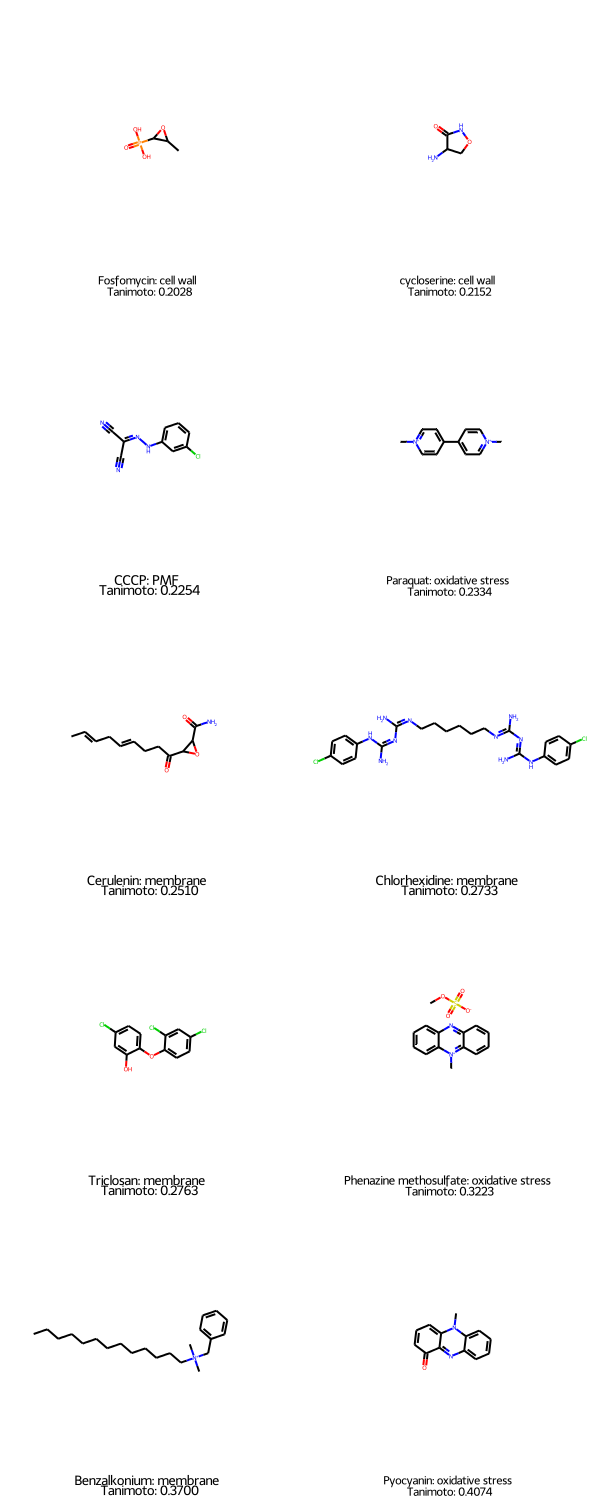

In [256]:
# showing structures of predicted compounds

mols = [Chem.MolFromSmiles(s) for s in test_df['smiles']]
# least_similar_legend = [name+': '+label+'\nGPC pred: '+gpc_pred+' KNN pred: '+knn_pred+'\n Tanimoto: '+str(tanimoto)[:6] for name, label, gpc_pred, knn_pred, tanimoto in zip(test_df['Compound'],test_df['true_label'],test_df['gpc_fp_preds'],test_df['knn_fp_preds'],test_df['max_tanimotos'])]
least_similar_legend = [name+': '+label+'\n Tanimoto: '+str(tanimoto)[:6] for name, label, gpc_pred, knn_pred, tanimoto in zip(test_df['Compound'],test_df['true_label'],test_df['gpc_fp_preds'],test_df['knn_fp_preds'],test_df['max_tanimotos'])]
least_similar_img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300,300), returnPNG=False, maxMols=10, legends=least_similar_legend)
least_similar_img.show()
# least_similar_img.save('../outputs/brochados_least_similar_predictions.png')

In [300]:
# displaying t-SNE of Brochado compounds
pca = PCA(n_components=50)
crds = pca.fit_transform(labeled_fps)

%time crds_embedded = TSNE(n_components=3).fit_transform(crds)

# regenerate brochado_dict from dataset_analysis.ipynb
brochado_dict = {}
brochado_names = labeled_drugs['Compound'][brochado_mask].to_list()
brochado_fps = get_fps(labeled_drugs.copy()[brochado_mask])
brochado_labels = labeled_drugs['labels'][brochado_mask].to_list()
brochado_smiles = labeled_drugs['canon_SMILES'][brochado_mask].to_list()
training_mask = [label != 'brochados' for label in labeled_drugs['hold_out']]
training_names = labeled_drugs['Compound'][training_mask].to_list()
training_fps = get_fps(labeled_drugs.copy()[training_mask])
training_labels = labeled_drugs['labels'][training_mask].to_list()
for compound1, fp1 in zip(brochado_names, brochado_fps):
    hist = []
    max_label = 'none'
    for compound2, fp2, label in zip(training_names, training_fps, training_labels):
        tanimoto = DataStructs.TanimotoSimilarity(fp1,fp2)
        hist.append(tanimoto)
        if tanimoto >= np.max(hist):
            max_label = label
    brochado_dict[compound1] = (hist, max_label)

CPU times: user 11min 20s, sys: 3.8 s, total: 11min 24s
Wall time: 1min 12s


In [297]:
# creating 3D tsne
threeD_tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y","Z"])
threeD_tsne_df['label'] = labeled_drugs['labels'].to_list()
threeD_tsne_df['compound'] = labeled_drugs['Compound'].to_list()
brochados_tsne_df = threeD_tsne_df.copy()
brochados_tsne_df['Compound'] = labeled_drugs['Compound']
brochados_tsne_df.insert(len(df.columns.values)+1,'max_similarity','')
brochados_tsne_df.insert(len(df.columns.values)+1,'max_similarity_class','')
brochados_tsne_df.loc[brochado_mask,'max_similarity'] = [np.max(brochado_dict[compound][0]) for compound in brochado_names]
brochados_tsne_df.loc[brochado_mask,'max_similarity_class'] = [brochado_dict[compound][1] for compound in brochado_names]
for cpd, true_label in zip(test_df['Compound'],test_df['true_label']):
    for idx in range(len(brochados_tsne_df)):
        if cpd == brochados_tsne_df.iloc[idx,4]:
            brochados_tsne_df.iloc[idx,3] = cpd+' '+true_label

In [298]:
fig = px.scatter_3d(brochados_tsne_df, x='X', y='Y', z='Z', color='label',title='t-SNE of least similar antibiotics from Brochados et al.', color_discrete_sequence=px.colors.qualitative.Alphabet,hover_data=['max_similarity','max_similarity_class'], opacity=0.7)
fig.show()